In [14]:
import os, re, glob  
import cv2  #openCV 라이브러리 import하기
import numpy as np  
from sklearn.model_selection import train_test_split 
from google.colab.patches import cv2_imshow
import cv2

In [15]:
from PIL import Image


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!cp /content/drive/MyDrive/tmp/teameyes.zip .
!unzip teameyes.zip

Archive:  teameyes.zip
replace eyes/data/test/close/image10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
groups_folder_path = '/content/eyes/data/train'
categories = ["close" , "open"]
nb_classes = len(categories) #카테고리갯수: 4개

image_w = 34
image_h = 26


X = []
y = []
for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)] #one-hot으로 라벨을 붙혀줌
    label[idx] = 1

    image_dir = groups_folder_path + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)      #폴더를 열어주고 이미지를 읽음
        img = img.convert("L")   #RGB로 바꿈
         
        
        data = np.asarray(img) #숫자로


        X.append(data) #리스트에 추가 
        y.append(label)


X = np.array(X)
y = np.array(y)
#y = np.argmax(y,axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y) #데이터를 훈련셋과 시험셋으로 나눠주는 함수이용
xy = (X_train, X_test, y_train, y_test)
X_train = X_train.reshape(2391,26,34,1)
y_train = np.argmax(y_train , axis = 1)
y_train = y_train.reshape(2391,1)

X_test = X_test.reshape(797,26,34,1)

y_test = np.argmax(y_test , axis = 1)
y_test = y_test.reshape(797,1)

np.save("multi_image_data.npy", xy) #그렇게 xy를 multi_image_data.npy로 저장

print("ok", len(y))

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10, # 0 ~ 180
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=False 
)
iterator = datagen.flow(X_train, y_train, batch_size=1024)

In [20]:
item = next(iterator)
augmented_x, augmented_y = item
print(augmented_x.shape)
print(augmented_y.shape)

(1024, 26, 34, 1)
(1024, 1)


In [21]:

print(y_test.shape)

X_train = X_train.reshape(2391,26,34,1)
print(y_train.shape)
y_train = np.argmax(y_train , axis = 1)
y_train = y_train.reshape(2391,1)


X_test = X_test.reshape(797,26,34,1)
print(y_test.shape)
y_test = np.argmax(y_test , axis = 1)
y_test = y_test.reshape(797,1)

cv2_imshow(X_test[2])
print(y_test[2])
print(X_test[2].shape)
cv2_imshow(X_test[0])

(797, 1)
(2391, 1)
(797, 1)


[0]
(26, 34, 1)


In [22]:
data_count = len(X_train)
print("data_count :", data_count)

WANTED_MULTIPLE_COUNT = 2
print("WANTED_MULTIPLE_COUNT :", WANTED_MULTIPLE_COUNT)

STEP_COUNT = int(data_count/1024)+1
print("STEP_COUNT :", STEP_COUNT)

FETCH_COUNT = STEP_COUNT*WANTED_MULTIPLE_COUNT
print("FETCH_COUNT :", FETCH_COUNT)


augmented_x_list = []
augmented_y_list = []
for i in range(FETCH_COUNT):
  item = next(iterator)
  augmented_x, augmented_y = item
  augmented_x_list.extend(augmented_x)
  augmented_y_list.extend(augmented_y)
  # print(len(augmented_x_list))
# python list를 numpy로 변환
augmented_train_x = np.array(augmented_x_list)
augmented_train_y = np.array(augmented_y_list)

print(augmented_train_x.shape)
print(augmented_train_y.shape)

data_count : 2391
WANTED_MULTIPLE_COUNT : 2
STEP_COUNT : 3
FETCH_COUNT : 6
(4782, 26, 34, 1)
(4782, 1)


In [23]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

In [24]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import Callback

In [26]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(
    augmented_train_x,augmented_train_y, epochs=100 ,validation_data = (X_test , y_test),
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
   
)

#model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss',  save_best_only=True)

#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_learning_rate=0.001)
#log_dir = "./logs"


#callbacks = [model_check_point,  early_stopping, reduce_lr]


#history = model.fit(augmented_train_x, augmented_train_y, epochs=300, batch_size=128, verbose=0, validation_split=0.2,
                      #   callbacks=callbacks)

#plt.plot(history.history['loss'], label='train_loss')
#plt.plot(history.history['val_loss'], label='val_loss')
#plt.legend()
#plt.show()

Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 0.9211 - acc: 0.9003
Epoch 1: val_acc improved from -inf to 0.30615, saving model to models/2022_08_01_03_08_03.h5
150/150 [==============================] - 16s 18ms/step - loss: 0.9211 - acc: 0.9003 - val_loss: 6.2266 - val_acc: 0.3061 - lr: 0.0010
Epoch 2/100
149/150 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9885
Epoch 2: val_acc did not improve from 0.30615
150/150 [==============================] - 2s 11ms/step - loss: 0.0371 - acc: 0.9883 - val_loss: 12.6690 - val_acc: 0.2974 - lr: 0.0010
Epoch 3/100
146/150 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9906
Epoch 3: val_acc did not improve from 0.30615
150/150 [==============================] - 2s 11ms/step - loss: 0.0279 - acc: 0.9908 - val_loss: 14.4132 - val_acc: 0.2986 - lr: 0.0010
Epoch 4/100
145/150 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9892
Epoch 4: val_acc did not improve from 

KeyboardInterrupt: ignored

In [ ]:
model.save("eyedect_teameye.h5")

In [ ]:
print(model.predict(np.expand_dims(X_test[4], axis = 0)))

cv2_imshow(X_test[4])

Epoch 1/100
148/150 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9985
Epoch 1: val_acc improved from -inf to 0.29486, saving model to models/2022_08_01_03_08_03.h5
150/150 [==============================] - 1s 8ms/step - loss: 0.0031 - acc: 0.9985 - val_loss: 34.9577 - val_acc: 0.2949 - lr: 4.0000e-05
Epoch 2/100
148/150 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9989
Epoch 2: val_acc did not improve from 0.29486
150/150 [==============================] - 1s 9ms/step - loss: 0.0030 - acc: 0.9990 - val_loss: 35.8217 - val_acc: 0.2923 - lr: 4.0000e-05
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.0029 - acc: 0.9987
Epoch 3: val_acc did not improve from 0.29486
150/150 [==============================] - 1s 9ms/step - loss: 0.0029 - acc: 0.9987 - val_loss: 36.6861 - val_acc: 0.2911 - lr: 4.0000e-05
Epoch 4/100
143/150 [===========================>..] - ETA: 0s - loss: 0.0030 - acc: 0.9987
Epoch 4: val_acc did not impr

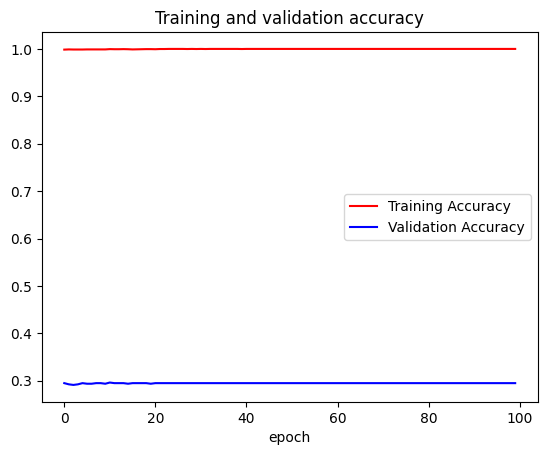

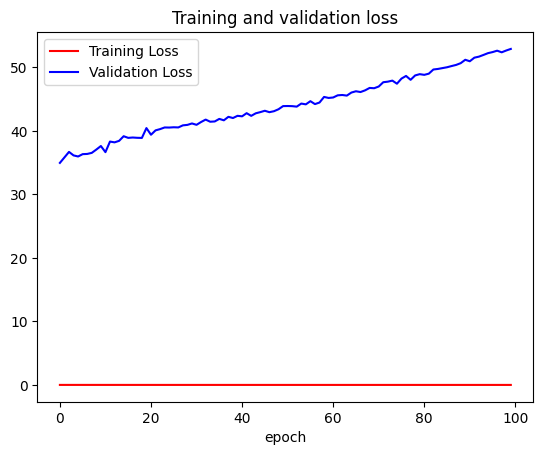

In [27]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
plt.style.use('default')

history = model.fit(
    augmented_train_x,augmented_train_y, epochs=100 ,validation_data = (X_test , y_test),
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
   
)
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.xlabel("epoch")
plt.legend(labels = ["Training Accuracy", "Validation Accuracy"], loc = "best")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and validation loss')
plt.xlabel("epoch")
plt.legend(labels = ["Training Loss", "Validation Loss"], loc = "best")

plt.show()